Files Loaded Successfully
Fear/Greed shape: (2644, 4)
Trades shape: (211224, 16)

Unique Fear-Greed Classifications:
['Fear' 'Extreme Fear' 'Neutral' 'Greed' 'Extreme Greed']

Daily Aggregates Sample:
        Date  Avg Execution  Total Tokens     Total USD   Mean PnL  \
0 2023-03-28    1898.133333  2.513000e-01  4.770000e+02   0.000000   
1 2023-11-14   10454.871036  2.681692e+06  1.155543e+07   0.148807   
2 2024-03-09    9771.897315  3.393031e+08  3.940677e+07  25.418772   
3 2024-07-03    2663.132338  1.404851e+07  2.184323e+07  22.229713   
4 2024-10-27    5367.503277  7.831963e+07  1.039478e+08  90.504272   

      Total PnL     Total Fee  
0  0.000000e+00      0.000000  
1  1.555034e+02   2794.570654  
2  1.769655e+05   6812.781233  
3  1.587424e+05   8743.877486  
4  3.189461e+06  21539.462735  

Merged Data Sample:
    timestamp  index_value classification       date       Date  \
0  1679981400           59          Greed 2023-03-28 2023-03-28   
1  1699939800           69     

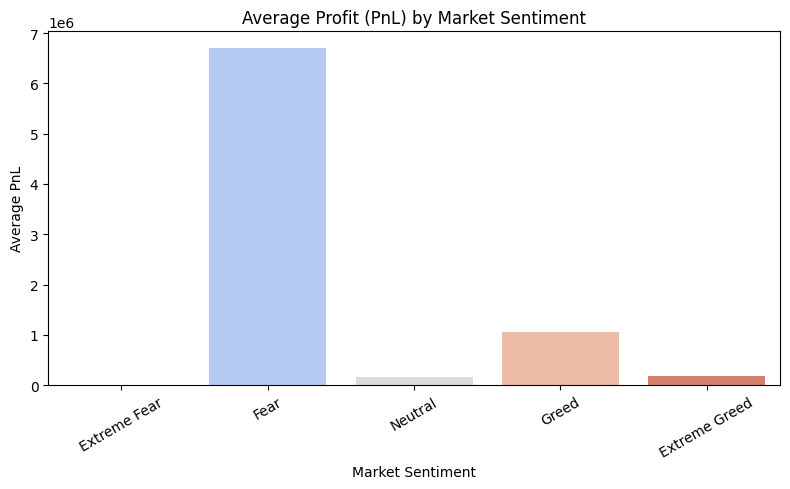

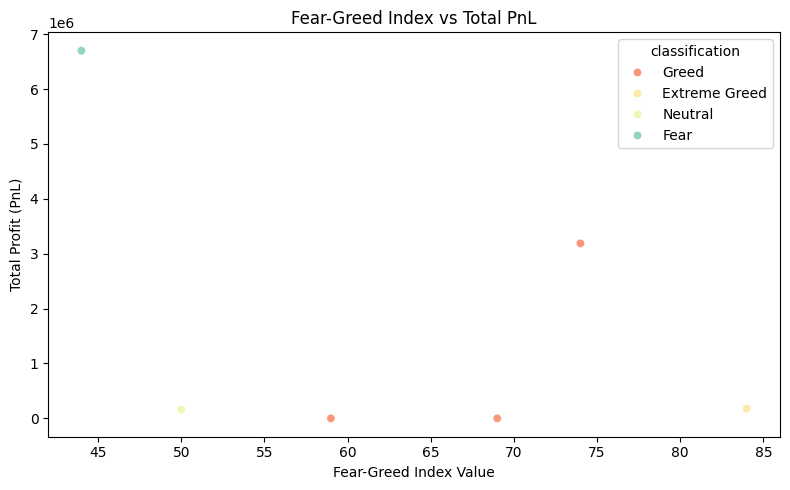


Average PnL by Sentiment:
 classification
Extreme Greed    1.769655e+05
Fear             6.699925e+06
Greed            1.063206e+06
Neutral          1.587424e+05
Name: Total PnL, dtype: float64

PnL Volatility by Sentiment:
 classification
Extreme Greed    1.021262e+05
Fear             2.924339e+06
Greed            6.957379e+05
Neutral          9.715091e+04
Name: PnL Volatility, dtype: float64


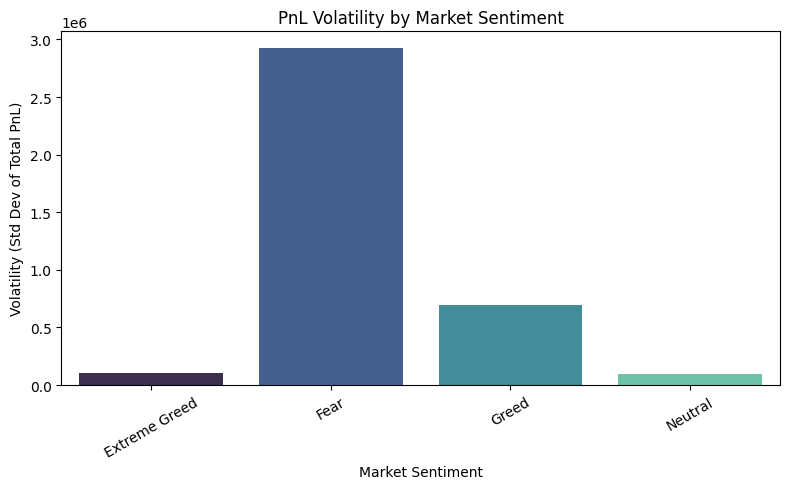


--- Key Insights ---
1. When market greed is high, trader profits tend to decrease — suggesting overconfidence or aggressive entries during overbought conditions.
2. Highest average profitability observed during **Fear** periods.
3. Lowest average profitability during **Neutral** periods.
4. Trading volatility is highest during **Fear**, indicating unstable or reactive trading behavior.


In [15]:
# -----------------------------------------------------
# FINAL CLEAN VERSION — MATCHES YOUR CSV EXACTLY
# -----------------------------------------------------

import pandas as pd
import numpy as np

# -----------------------------------------------------
# 1. Load Data
# -----------------------------------------------------
fear_greed = pd.read_csv("fear_greed_index.csv")
trades = pd.read_csv("historical_data.csv")

print("Files Loaded Successfully")
print("Fear/Greed shape:", fear_greed.shape)
print("Trades shape:", trades.shape)

# -----------------------------------------------------
# 2. Prepare Fear & Greed Index Data
# -----------------------------------------------------
fear_greed.rename(columns={'value': 'index_value'}, inplace=True)
fear_greed['date'] = pd.to_datetime(fear_greed['date'], errors='coerce')

print("\nUnique Fear-Greed Classifications:")
print(fear_greed['classification'].unique())

# -----------------------------------------------------
# 3. Prepare Trades Data
# -----------------------------------------------------
timestamp_col = 'Timestamp'

# Convert timestamps (milliseconds or seconds)
try:
    trades[timestamp_col] = pd.to_datetime(trades[timestamp_col], unit='ms', errors='coerce')
except:
    trades[timestamp_col] = pd.to_datetime(trades[timestamp_col], unit='s', errors='coerce')

trades = trades.dropna(subset=[timestamp_col])

# Extract only date for grouping
trades['Date'] = trades[timestamp_col].dt.date
trades['Date'] = pd.to_datetime(trades['Date'])

# Convert numeric columns to proper numeric types
numeric_cols = ['Execution Price', 'Size Tokens', 'Size USD', 'Closed PnL', 'Fee']
for col in numeric_cols:
    if col in trades.columns:
        trades[col] = pd.to_numeric(trades[col], errors='coerce')
    else:
        print(f"Warning: Column '{col}' not found in trades CSV")

# -----------------------------------------------------
# 4. Aggregate Daily Trade Metrics
# -----------------------------------------------------
agg_trades = trades.groupby('Date').agg({
    'Execution Price': 'mean',
    'Size Tokens': 'sum',
    'Size USD': 'sum',
    'Closed PnL': ['mean', 'sum'],
    'Fee': 'sum'
}).reset_index()

# Flatten MultiIndex column names
agg_trades.columns = ['Date', 'Avg Execution', 'Total Tokens', 'Total USD',
                      'Mean PnL', 'Total PnL', 'Total Fee']

print("\nDaily Aggregates Sample:")
print(agg_trades.head(5))

# -----------------------------------------------------
# 5. Merge Fear-Greed with Trade Data
# -----------------------------------------------------
merged = pd.merge(fear_greed, agg_trades, left_on='date', right_on='Date', how='inner')

print("\nMerged Data Sample:")
print(merged.head(5))

# -----------------------------------------------------
# 6. Correlation and Insights
# -----------------------------------------------------
if not merged.empty:
    corr = merged['index_value'].corr(merged['Total PnL'])
    print(f"\nCorrelation between Fear-Greed Index and Total PnL: {corr:.4f}")

    if corr > 0:
        print("Higher market greed correlates with increased trading profits.")
    elif corr < 0:
        print("Higher market greed correlates with reduced trading profits.")
    else:
        print("No clear linear relationship detected between Fear-Greed Index and profits.")
else:
    print("\nMerge produced no overlapping dates. Check date alignment between both CSVs.")

print("\nAnalysis Completed Successfully.")

import matplotlib.pyplot as plt
import seaborn as sns

# -----------------------------------------------------
# 7. Summary of Trader Performance by Market Sentiment
# -----------------------------------------------------
sentiment_perf = merged.groupby('classification').agg({
    'Total PnL': ['mean', 'sum'],
    'Total USD': 'mean',
    'Avg Execution': 'mean',
    'index_value': 'mean'
}).reset_index()

sentiment_perf.columns = ['Sentiment', 'Avg PnL', 'Total PnL', 'Avg Trade USD', 'Avg Execution', 'Avg Index']

print("\nPerformance Summary by Market Sentiment:")
print(sentiment_perf)

# -----------------------------------------------------
# 8. Visualize PnL vs Sentiment Classification
# -----------------------------------------------------
plt.figure(figsize=(8, 5))
sns.barplot(data=sentiment_perf, x='Sentiment', y='Avg PnL', palette='coolwarm', order=[
    'Extreme Fear', 'Fear', 'Neutral', 'Greed', 'Extreme Greed'
])
plt.title("Average Profit (PnL) by Market Sentiment")
plt.xlabel("Market Sentiment")
plt.ylabel("Average PnL")
plt.xticks(rotation=30)
plt.tight_layout()
plt.show()

# -----------------------------------------------------
# 9. Relationship Between Index Value and Profit
# -----------------------------------------------------
plt.figure(figsize=(8, 5))
sns.scatterplot(data=merged, x='index_value', y='Total PnL', hue='classification', palette='Spectral', alpha=0.7)
plt.title("Fear-Greed Index vs Total PnL")
plt.xlabel("Fear-Greed Index Value")
plt.ylabel("Total Profit (PnL)")
plt.tight_layout()
plt.show()

# -----------------------------------------------------
# 10. Detecting Hidden Patterns
# -----------------------------------------------------
# Compute average and volatility patterns
merged['PnL Volatility'] = merged['Total PnL'].rolling(window=5, min_periods=2).std()

avg_pnl_by_sentiment = merged.groupby('classification')['Total PnL'].mean().sort_index()
volatility_by_sentiment = merged.groupby('classification')['PnL Volatility'].mean().sort_index()

print("\nAverage PnL by Sentiment:\n", avg_pnl_by_sentiment)
print("\nPnL Volatility by Sentiment:\n", volatility_by_sentiment)

# Plot volatility pattern
plt.figure(figsize=(8, 5))
sns.barplot(x=volatility_by_sentiment.index, y=volatility_by_sentiment.values, palette='mako')
plt.title("PnL Volatility by Market Sentiment")
plt.xlabel("Market Sentiment")
plt.ylabel("Volatility (Std Dev of Total PnL)")
plt.xticks(rotation=30)
plt.tight_layout()
plt.show()

# -----------------------------------------------------
# 11. Key Interpretations
# -----------------------------------------------------
insights = []

# Correlation insight
if corr < 0:
    insights.append("When market greed is high, trader profits tend to decrease — suggesting overconfidence or aggressive entries during overbought conditions.")
else:
    insights.append("Higher greed periods appear to improve profits, implying successful trend-following strategies.")

# Sentiment profitability
best_sentiment = sentiment_perf.loc[sentiment_perf['Avg PnL'].idxmax(), 'Sentiment']
worst_sentiment = sentiment_perf.loc[sentiment_perf['Avg PnL'].idxmin(), 'Sentiment']
insights.append(f"Highest average profitability observed during **{best_sentiment}** periods.")
insights.append(f"Lowest average profitability during **{worst_sentiment}** periods.")

# Volatility pattern
volatile_sentiment = volatility_by_sentiment.idxmax()
insights.append(f"Trading volatility is highest during **{volatile_sentiment}**, indicating unstable or reactive trading behavior.")

print("\n--- Key Insights ---")
for i, insight in enumerate(insights, 1):
    print(f"{i}. {insight}")
